## Keras implementation of AnoGAN 

https://arxiv.org/abs/1703.05921

<b> Abstract </b>

질병의 예후를 모니터링하기 위해 이미지 마커를 잡아내는 모델을 얻는 것은 매우 어려운 일이다. 보통의 모델은 자동 감지를 위해 알려진 마커의 주석이 달린 예제를 사용하여 많은 양의 데이터를 기반으로 한다. 주석처리(라벨링) 작업과 이미 알려진 것들에 대해서만 탐지 가능하다는 점은 그런 방식의 단점을 작용한다 이 논문은 이미지에서 어노말리를 찾기 위해 비지도학습 이용하다. 우리가 제안한 anoGAN은 정상적인 변동성의 다양함(정상 데이텅의 분포)를 학습한 DCGAN과 이미지 공간에서 잠재공간으로의 매핑방식을 기반으로 어노말리 스코어를 계산한다. 새로운 데이터에 적용했을때 모델은 어노말리와 어노말리 스코어를 계산한다. 이 방식을 망막의 광학 단층 촬영 영상에 적용한 결과, 망막 유체 또는 반사성 초점을 포함하는 이미지와 같은 변칙적인 영상(어노말리)을 정확하게 식별함을 확인하였다.


![anoGAN](assets/anoGAN.png)

<b> 1.train DCGAN with normal image </b>
* Radford, A., Metz, L., Chintala, S.: Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv:1511.06434 (2015)

<b> 2.Mapping new Images to the Latent Space </b>
* 신규데이터(a query image x)가 들어오면 우리는 신규이미지 x와 시각적으로 가장 유사한 이미지 G(z)에 대응하는 z를 찾는 것이 목적이다. 
* best z를 찾기위해 처음에는 랜덤하게 뽑은 z1를 학습된 generator에 입력값으로 넣어 G(z1)를 얻는다.
* G(z1)를 기준으로 loss를 계산한다. 이때 loss는 latent space에서 z1이 z2로 이동을 의미하는 z1의 coefficient를 업데이트할 그래디언트 역할을 한다. (z2 = c * z1, c는 backpropagation을 통해 결정)
* 신규데이터와 가장 유사한 G(z)를 찾기 위해, latent space에서 z의 위치는 역전파를 통한 반복적인 계산을 통해 최적화된다. (500 backpropagation steps)

    <b> 2.1 loss </b>
    - z를 최적화기위해 사용한 loss는 2가지로 구성된다. 
    - residual loss : G(z)와 x와의 차이값 
    ![residual_loss](assets/residual.png)
    - discrimination loss : discriminator의 중간레이어 결과값의 차이
    ![discrimination_loss](assets/discrimination.png)
        f(·) : output of an intermediate layer  of the discriminator 
    - overall loss : residual loss와 discrimination loss의 가중합 (논문에서 사용한 람다=0.1)
    ![overall_loss](assets/overall.png)

<b> 3.anomaly score </b>
* 2의 맵핑과정을 통해 최종적으로 얻은 loss값을 사용한다
* 또한 신규이미지에서 anomaly의 영역을 규명하기위해 가장 유사한 이미지와 신규이미지와의 차이 이미지(residual image)를 사용하였다. 
![residual_img](assets/residual_img.png)


![anoGAN2](assets/anoGAN2.png)




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm
import anogan
import csv

file = open('./data_channel1_2.csv', 'r')
reader = csv.reader(file)
entire_data = []
for row in reader:
    entire_data.append(list(map(float, row)))

entire_data = np.array(entire_data)

# Model_d, Model_g = anogan.train(32, X_train)

In [2]:
entire_data = entire_data.reshape(entire_data.shape[0] * entire_data.shape[1])
entire_data = entire_data[:-72].reshape(98796, 512)

In [3]:
entire_data.shape[0]

98796

In [4]:
X_train = entire_data[:int(entire_data.shape[0] * 0.9)]
X_test = entire_data[int(entire_data.shape[0]*0.9):]

In [5]:
X_train.shape, X_test.shape

((88916, 512), (9880, 512))

In [6]:
X_train[0][0], X_train[1][-1]

(0.020879084463196813, 0.020762885491150976)

In [7]:
X_train = X_train.reshape(1477, 34120)[:-1]
X_test = X_test.reshape(5, 34120)

ValueError: cannot reshape array of size 45524992 into shape (1477,34120)

In [8]:
X_train.shape

(88916, 512)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
scale = scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [11]:
X_train.shape

(88916, 512)

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [34]:
import anogan

Model_d, Model_g = anogan.train(1000, 64, X_train)

#### discriminator ######
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 256, 32)           192       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 256, 32)           0         
                                                                 
 dropout_10 (Dropout)        (None, 256, 32)           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 126, 64)           10304     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 126, 64)           0         
                                                                 
 dropout_11 (Dropout)        (None, 126, 64)           0         
                                                                 
 flatten_5 (Flatten)       

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
## generate random image 

generated_img = anogan.generate(10)
generated_img.shape

1/1 [==============================] - 0s 137ms/step


(10, 512, 1)

In [17]:
generated_img.reshape(5120)

array([0.4472385 , 0.6222544 , 0.51094866, ..., 0.38802317, 0.38133708,
       0.54008996], dtype=float32)

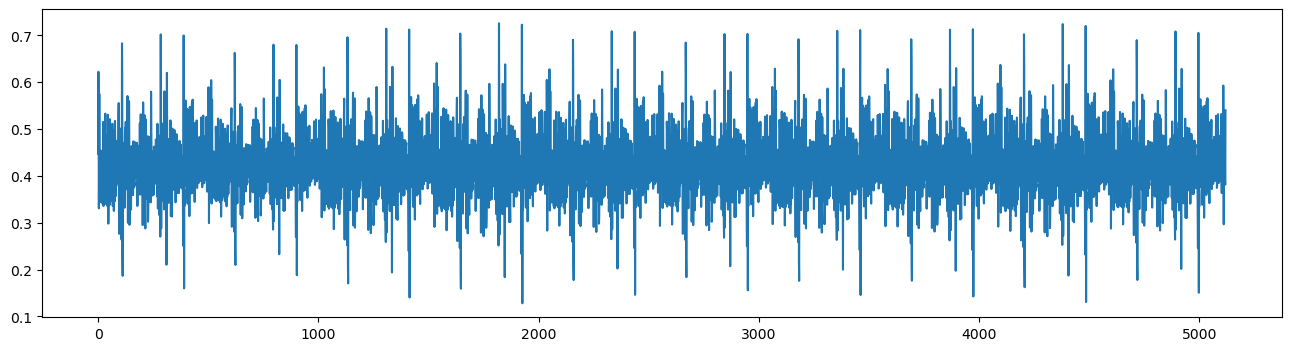

In [18]:

plt.figure(figsize=(16,4))
plt.plot(generated_img.reshape(5120))
plt.show()

1/1 [==============================] - 2s 2s/step


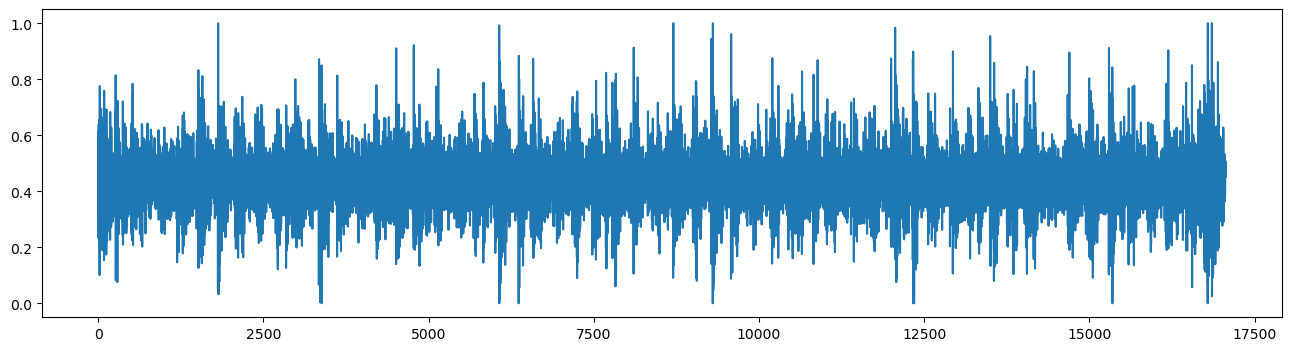

anomaly score : 1857.263427734375


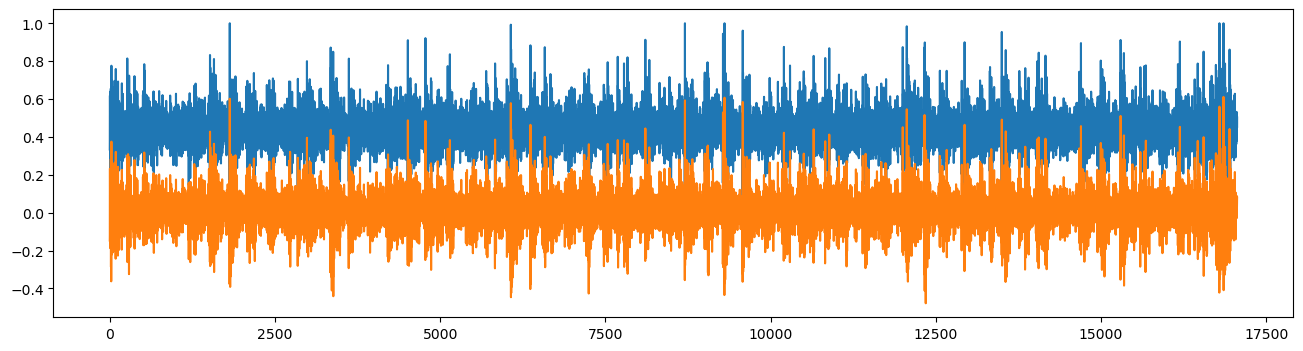

In [ ]:
## compute anomaly score - sample from test set

X_test = X_test.reshape(-1, 17060, 1)
test_img = X_test[0]

model = anogan.anomaly_detector()
ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 17060, 1))

plt.figure(figsize=(16, 4))
plt.plot(test_img.reshape(17060))
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(16, 4))
plt.plot(test_img.reshape(17060))
residual  = test_img.reshape(17060) - similar_img.reshape(17060)
plt.plot(residual)
plt.show()

In [20]:
import anogan

## compute anomaly score - sample from strange image

# test_img = plt.imread('assets/test_img.png')
test_img = X_train[100]
# test_img = test_img[:,:,0]

model = anogan.anomaly_detector()
ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 512, 1))

# plt.figure(figsize=(16, 4))
# plt.plot(test_img.reshape(17060))
# plt.show()
# print("anomaly score : " + str(ano_score))
# plt.figure(figsize=(16, 4))
# plt.plot(test_img.reshape(17060))
# residual  = test_img.reshape((17060)) - similar_img.reshape(17060)
# plt.plot(residual)
# plt.plot(similar_img.reshape(17060))
# plt.show()


1/1 [==============================] - 0s 100ms/step


In [23]:
ano_score

46.211448669433594

In [ ]:
import keras.layers
import keras.models

def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

g = anogan.generator_model()
g.load_weights('assets/generator')
g.trainable = False
intermediate_model = anogan.feature_extractor()
intermediate_model.trainable = False

aInput = keras.layers.Input(shape=(20,))
gInput = keras.layers.Dense((20))(aInput)
G_out = g(gInput)
D_out = intermediate_model(G_out)
model = keras.models.Model(inputs=aInput, outputs=[G_out, D_out])
model.compile(loss=sum_of_residual, optimizer='adam')

In [ ]:
import numpy as np

z = np.random.uniform(0, 1, size=(1, 20))
intermediate_model = anogan.feature_extractor()
d_x = intermediate_model.predict(test_img.reshape(1, 17060, 1))

1/1 [==============================] - 0s 34ms/step


In [ ]:
similar_data, _ = model(z)
# return loss.history['loss'][-1], similar_data

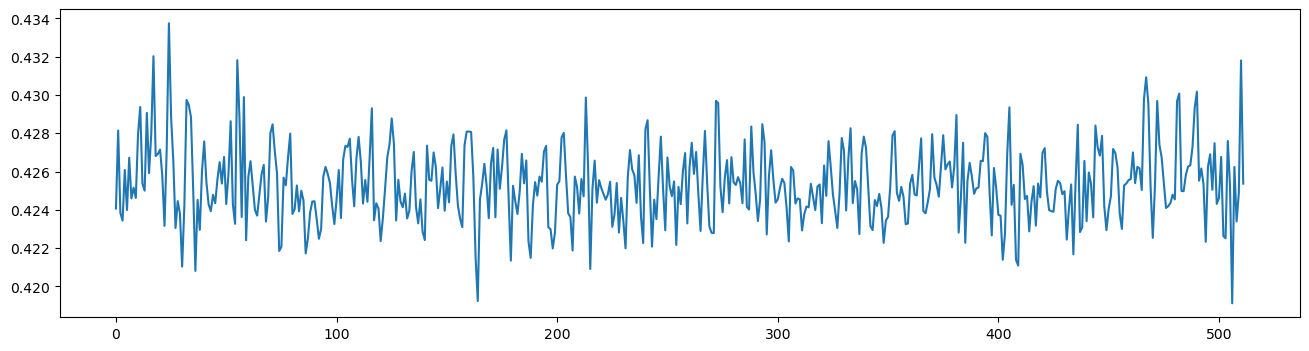

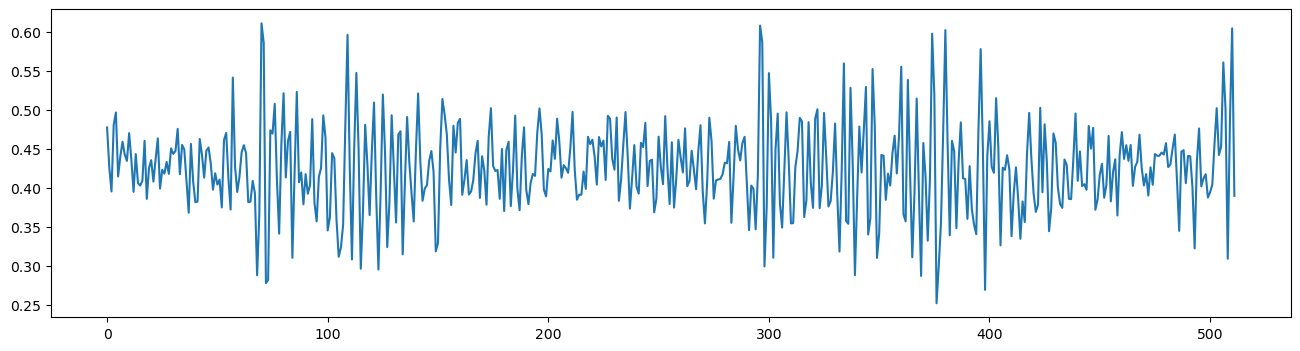

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=[16,4])
# plt.plot(test_img.reshape(512))
plt.plot(similar_img[0])
plt.show()
plt.figure(figsize=[16,4])
plt.plot(X_test[9033].reshape(512))
plt.show()

a sample from generated anomaly images(random noise image)


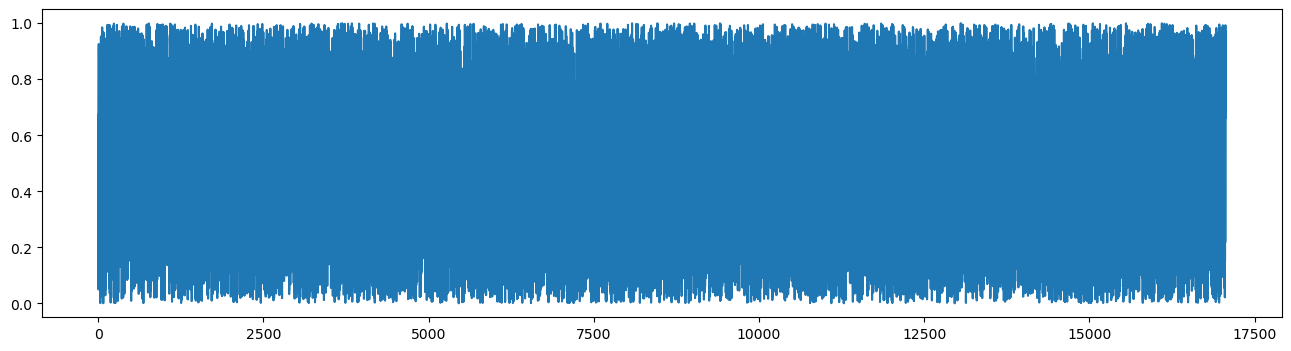

1/1 [==============================] - 0s 25ms/step


c:\Users\dk866\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\dk866\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


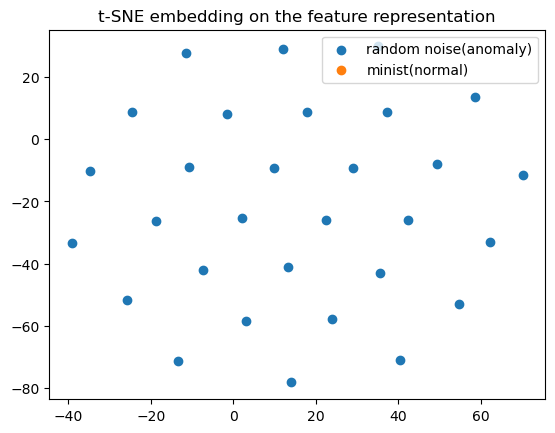

In [ ]:
from sklearn.manifold import TSNE

## t-SNE embedding 

# generating anomaly image for test (radom noise image)

random_image = np.random.uniform(0,1, (20, 17060, 1))
print("a sample from generated anomaly images(random noise image)")
plt.figure(figsize=(16, 4))
plt.plot(random_image[0].reshape(17060))
plt.show()

# intermidieate output of discriminator
model = anogan.feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test[:300], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:,0], X_embedded[100:,1], label='minist(normal)')
plt.legend()
plt.show()

In [ ]:
import csv
import os

nasa = []
file = open('../data/set1_b3_inner_race_defect.csv', 'r')
reader = csv.reader(file)
cnt = 1
for row in reader:
    if cnt == 1:
        cnt +=1 
        continue
    nasa.append(list(map(float, row)))

In [ ]:
nasa = np.array(nasa)
nasa.shape

(44152724, 2)

In [ ]:
nasa = nasa[:, 1]

In [ ]:
max(nasa.reshape(44151280))

1.0000000000000002

In [ ]:
scaler_for_nasa = scale.fit(nasa[:-1444].reshape(2588, 17060))

In [ ]:
nasa = scaler_for_nasa.transform(nasa[:-1444].reshape(2588, 17060))

1/1 [==============================] - 2s 2s/step


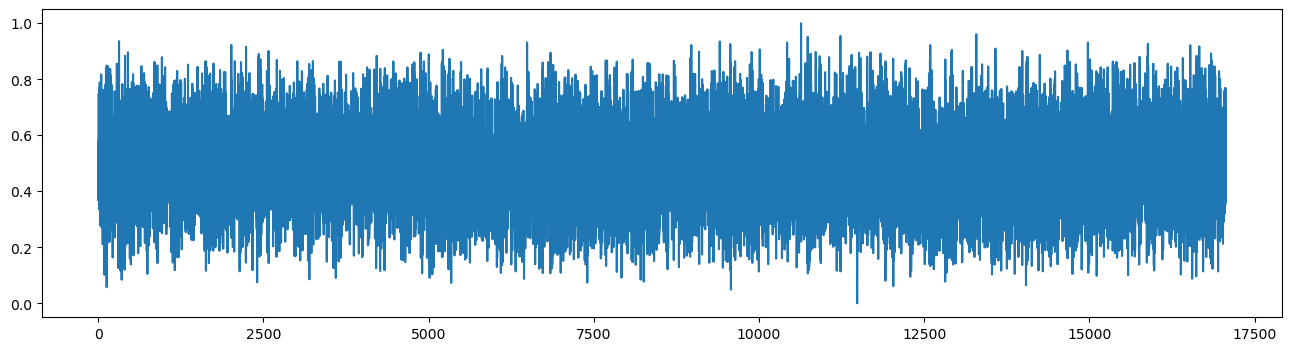

anomaly score : 3803.73291015625


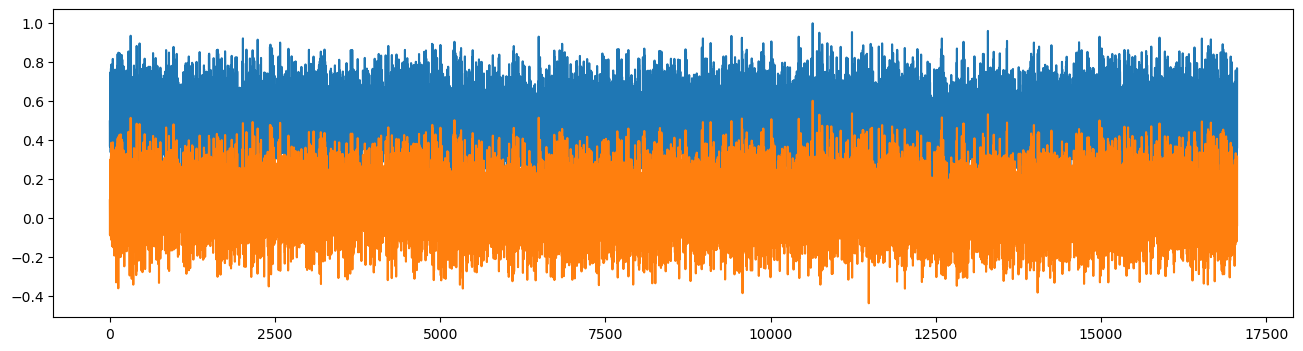

In [ ]:
## compute anomaly score - sample from test set

import anogan as anogan

nasa = nasa.reshape(2588, 17060, 1)
test_img = nasa[478]

model = anogan.anomaly_detector()
ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 17060, 1))

plt.figure(figsize=(16, 4))
plt.plot(test_img.reshape(17060))
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(16, 4))
plt.plot(test_img.reshape(17060))
residual  = test_img.reshape(17060) - similar_img.reshape(17060)
plt.plot(residual)
plt.show()

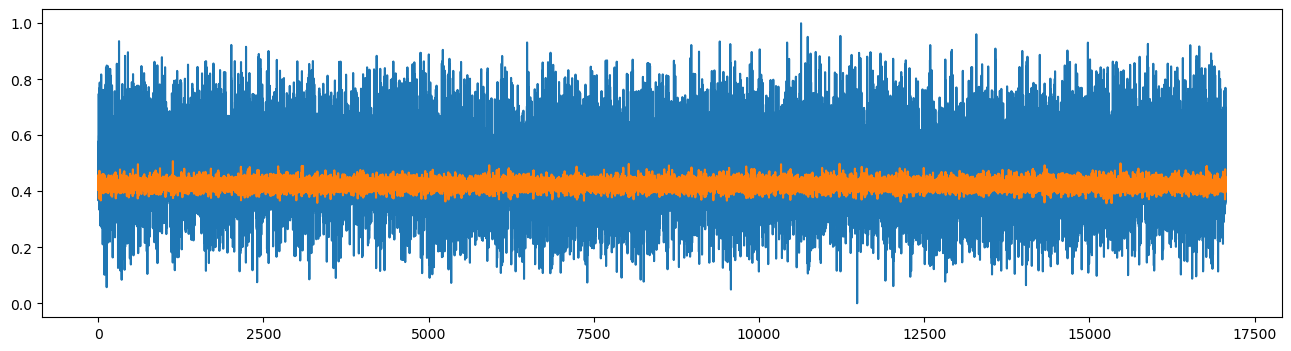

In [ ]:

plt.figure(figsize=(16, 4))
plt.plot(test_img.reshape(17060))
plt.plot(similar_img.reshape(17060))
plt.show()

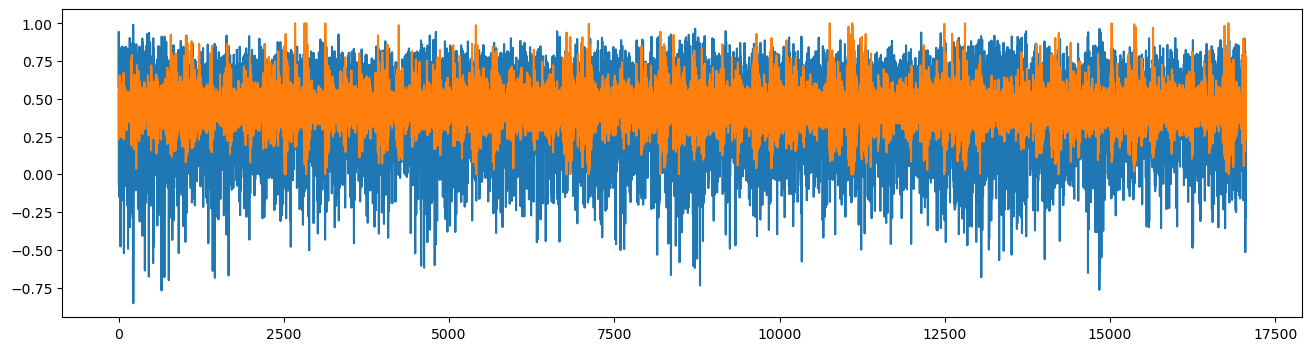

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(similar_img.reshape(17060))
plt.plot(X_train[379].reshape(17060))
plt.show()

In [ ]:
max(nasa[478])

array([2.91898658])

In [ ]:
Model_g.save_weights('assets/generator_1000_origin', True)
Model_d.save_weights('assets/discriminator_1000_origin', True)